<a href="https://colab.research.google.com/github/Ilvecho/Project_3/blob/main/P3_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install thefuzz[speedup]

In [2]:
import numpy as np
import pandas as pd
import re
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from thefuzz import fuzz
from thefuzz import process
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')



from google.colab import files
files.upload()
pass

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Saving potential-talents - Aspiring human resources - seeking human resources.csv to potential-talents - Aspiring human resources - seeking human resources.csv


In [3]:
raw_data = pd.read_csv('potential-talents - Aspiring human resources - seeking human resources.csv')

# convert the column connection from object to int
raw_data = raw_data.mask(raw_data == '500+ ', other=501)
raw_data.connection = pd.to_numeric(raw_data.connection)

# Preliminary data analysis

In [4]:
raw_data.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,501,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",501,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",501,NaN


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    int64  
 4   fit         0 non-null      float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.2+ KB


In [6]:
print(raw_data.isnull().sum())

id              0
job_title       0
location        0
connection      0
fit           104
dtype: int64


In [7]:
duplicate_rows = raw_data.duplicated(subset=['job_title', 'location', 'connection'])
print(duplicate_rows.sum())

51


there are 51 rows that are duplicates of already existing rows.
Note that to identify the duplicates we excluded the column 'id' as those are unique.

Ultimately, we need to understand whether these duplicate rows are actually duplicates, or simply represent different individuals with the same job title and number of connections.

I think that they are duplicate, as we detected rows with **excacly** the same job title and numebr of connections

In [8]:
# convert the column connection from object to int
raw_data = raw_data.mask(raw_data == '500+ ', other=501)
raw_data.connection = pd.to_numeric(raw_data.connection)

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    int64  
 4   fit         0 non-null      float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.2+ KB


Let's look at the data distribution for each feature

In [9]:
# let's start from the connection feature as it is the easiest to verify
raw_data.connection.value_counts()

501    44
85      7
61      7
44      6
1       5
2       4
4       2
7       2
57      2
390     2
103     1
48      1
18      1
71      1
19      1
415     1
9       1
64      1
39      1
155     1
349     1
174     1
40      1
50      1
268     1
455     1
52      1
409     1
212     1
16      1
5       1
82      1
49      1
Name: connection, dtype: int64

In [10]:
unique_data = raw_data[~duplicate_rows.values]
unique_data = unique_data.reset_index().drop('index', axis=1)

In [11]:
unique_data.shape

(53, 5)

In [12]:
job_title_similarity = np.zeros((unique_data.shape[0], unique_data.shape[0]))
location_similarity = np.zeros((unique_data.shape[0], unique_data.shape[0]))

In [13]:
for index, row in unique_data.iterrows():
  # compute the similarity for Job Title
  tmp = process.extract(row.job_title, unique_data.job_title, limit=60, scorer=fuzz.partial_token_set_ratio)
  for i in np.arange(len(tmp)):
    _, score, idx = tmp[i]
    job_title_similarity[index][idx] = score

  # compute the similarity for Location
  tmp = process.extract(row.location, unique_data.location, limit=60, scorer=fuzz.partial_token_set_ratio)
  for i in np.arange(len(tmp)):
    _, score, idx = tmp[i]
    location_similarity[index][idx] = score

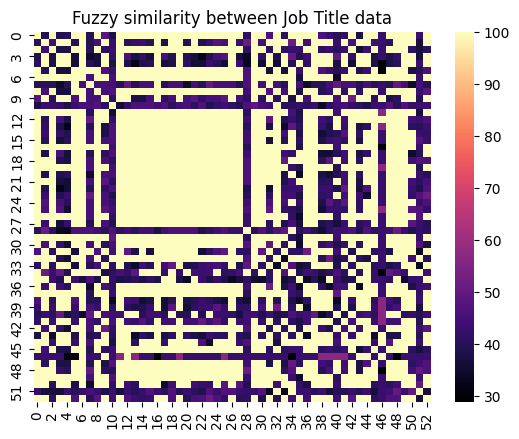

In [14]:
# plot the two results as heatmap
ax= plt.subplot()
sns.heatmap(job_title_similarity, cmap='magma', fmt='g', ax=ax);
ax.set_title('Fuzzy similarity between Job Title data');
plt.show()

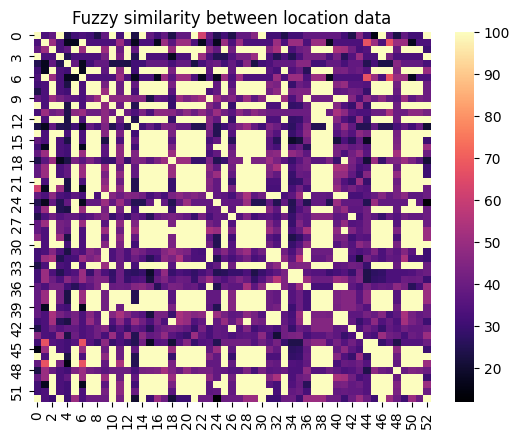

In [15]:
ax= plt.subplot()
sns.heatmap(location_similarity, cmap='magma', fmt='g', ax=ax);
ax.set_title('Fuzzy similarity between location data');
plt.show()

# Duplicates identification and extraction

In [16]:
# note that, contrary than before, we set the parameter keep to false to return all the duplicates
duplicate_rows_idx = raw_data.duplicated(subset=['job_title', 'location', 'connection'], keep=False)
duplicate_rows = raw_data[duplicate_rows_idx]
groups = duplicate_rows.groupby('job_title').groups

In [17]:
duplicates_dict = {}

for key in groups.keys():
  duplicates_dict[str(groups[key][0])] = groups[key].values

duplicates_dict

{'0': array([ 0, 13, 14, 18, 30, 43, 56]),
 '4': array([ 4, 22, 34, 47]),
 '26': array([26, 28]),
 '2': array([ 2, 16, 20, 32, 45, 57]),
 '5': array([ 5, 23, 35, 48, 59]),
 '7': array([ 7, 25, 37, 50, 60]),
 '12': array([12, 42, 55, 64]),
 '1': array([ 1, 15, 19, 31, 44]),
 '3': array([ 3, 17, 21, 33, 46, 58]),
 '11': array([11, 41, 54, 63]),
 '9': array([ 9, 39, 52, 61]),
 '27': array([27, 29]),
 '10': array([10, 40, 53, 62]),
 '6': array([ 6,  8, 24, 36, 38, 49, 51])}

Now that we mapped the duplicates with the fist occurrence, we can remove all the duplicate rows

In [18]:
duplicate_rows = raw_data.duplicated(subset=['job_title', 'location', 'connection'])
unique_data = raw_data[~duplicate_rows.values]
unique_data = unique_data.drop('id', axis=1)

# Pre processing - Location

Pre-processing of the column location:

The goal is to obtain either a country, or CITY, STATE for US cities

- Remove the word 'Area'
- Remove the word 'Greater'
- Substitute 'Kanada' with 'Canada'

In [19]:
duplicates_removed = False

if duplicates_removed:
  data = unique_data.copy()
else:
  data = raw_data.copy()

data.location = data.location.str.replace(' Area', '')
data.location = data.location.str.replace('Greater ', '')
data.location = data.location.str.replace('Kanada', 'Canada')

Now we need to identify different forms to indicate the same city: to do so we are going to use fuzzy matching

In [20]:
replacements = {}

for location in data.location.unique():
  # compute the similarity for Job Title
  tmp = process.extract(location, data.location.unique(), limit=3, scorer=fuzz.token_set_ratio)
  for i in np.arange(len(tmp)):
    # we have a match but the strings are not identical
    if tmp[i][1] > 90 and location != tmp[i][0]:
      # then, we replace the string WITHOUT comma (City name only) with the string WITH the comma (City, State)
      if ',' in location:
        replacements[tmp[i][0]] = location
      elif ',' in tmp[i][0]:
        replacements[location] = tmp[i][0]

for key in replacements.keys():
  data.location = data.location.mask(data.location == key, other=replacements[key])

In [21]:
# Manual touch to accomodate my tastes
data.location = data.location.str.replace('York,', 'York City,')

In [22]:
# let's now check the strings that still don't contain a comma
for location in data.location.value_counts().keys():
  if ',' not in location:
    print(location)

Canada
San Francisco Bay
Philadelphia
Amerika Birleşik Devletleri
Dallas/Fort Worth
Boston


In [23]:
# Manually fix this last surviving examples
data.location = data.location.str.replace('Philadelphia', 'Philadelphia, Pennsylvania')
data.location = data.location.str.replace('Dallas/Fort Worth', 'Dallas, Texas')
data.location = data.location.str.replace('Boston', 'Boston, Massachusetts')
data.location = data.location.str.replace('San Francisco Bay', 'San Francisco, California')

# Amerika Birleşik Devletleri in turkish means United States of America
data.location = data.location.str.replace('Amerika Birleşik Devletleri', 'United States')

In [24]:
# Now that we have (almost) all the locations as city, state
# we split them
city_list = []
state_list = []
country_list = []


for index, row in data.iterrows():
  # compute the similarity for Job Title
  if ',' not in row.location:
    city_list.append('')
    state_list.append('')
    country_list.append(row.location)
  elif 'rkiye' in row.location:
    city, country = row.location.split(', ')
    city_list.append(city)
    state_list.append('')
    country_list.append(country)
  else:
    city, state = row.location.split(', ')
    city_list.append(city)
    state_list.append(state)
    country_list.append('United States')

In [25]:
data['city'] = city_list
data['state'] = state_list
data['country'] = country_list

In [26]:
fig = px.bar(x=data.location.value_counts().keys(), y=data.location.value_counts(), title='Location bar plot')
fig.update_xaxes(tickangle=40)
fig.show()

In [27]:
fig = px.bar(x=data.city.value_counts().keys(), y=data.city.value_counts(), title='City bar plot')
fig.update_xaxes(tickangle=40)
fig.show()

In [28]:
fig = px.bar(x=data.state.value_counts().keys(), y=data.state.value_counts(), title='State bar plot')
fig.update_xaxes(tickangle=40)
fig.show()

In [29]:
fig = px.bar(x=data.country.value_counts().keys(), y=data.country.value_counts(), title='Country bar plot')
fig.update_xaxes(tickangle=40)
fig.show()

# Pre processing - Job Title

Remove digits and special characters

In [30]:
data['no_symbols'] = data['job_title'].apply(lambda x: re.sub('[^a-zA-Z0-9 ]', '', x.lower()))
data['no_symbols'] = data['no_symbols'].apply(lambda x: re.sub(' [ ]*', ' ', x))

Remove stopwords

In [31]:
stop = stopwords.words('english')

data['no_stopwords'] = data['no_symbols'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

Substitute Acronyms and abbreviations

We identified words with 4 characters or less and manually decided how to deal with them:

- Problematic word: ('c', 'JJ'): already removed in the lemmazation step
- Problematic word: ('cum', 'NN'): remove, it a stop word ('cum' in latin is 'with')
- Problematic word: ('epik', 'JJ'): remove, the acronym is already expanded
- Problematic word: ('ryan', 'NN'): ignore, name of a company
- Problematic word: ('hr', 'NN'): expand in 'human resource'
- Problematic word: ('hris', 'VBP'): expand in 'human resource information system'
- Problematic word: ('svp', 'NN'): expand in 'senior vice president'
- Problematic word: ('chro', 'NN'): expand in 'chief human resource officer'
- Problematic word: ('csr', 'VBP'): expand in 'corporate social responsibility'
- Problematic word: ('gphr', 'NN'): expand in 'global professional in human resources'
- Problematic word: ('sphr', 'NN'):  expand in 'senior professional in human resources'
- Problematic word: ('army', 'JJ'): ignore
- Problematic word: ('inc', 'NN'): remove
- Problematic word: ('work', 'NN'): ignore
- Problematic word: ('arts', 'NNS'): ignore
- Problematic word: ('mes', 'NNS'): expand in 'manufacturing execution system'
- Problematic word: ('heil', 'NN'): ignore, company name
- Problematic word: ('team', 'NN'): ignore
- Problematic word: ('gis', 'NN'): expand in 'geographic information system'
- Problematic word: ('rrp', 'NN'): expand in 'recommended retail price'
- Problematic word: ('jti', 'NN'): remove, already expanded
- Problematic word: ('love', 'NN'): ignore
- Problematic word: ('data', 'NNS'): ignore
- Problematic word: ('ey', 'VBP'): ignore, name of the company
- Problematic word: ('lab', 'NN'): ignore
- Problematic word: ('lead', 'JJ'): ignore
- Problematic word: ('care', 'NN'): ignore
- Problematic word: ('long', 'RB'): ignore
- Problematic word: ('open', 'VBP'): ignore
- Problematic word: ('may', 'MD'): this is actually removed by the lemmization
- Problematic word: ('st', 'NN'): expand in 'saint'
- Problematic word: ('set', 'VBN'): ignore

In [32]:
to_remove = {'cum', 'epik', 'inc', 'jti'}
to_replace = {
    'hr': 'human resources',
    'hris': 'human resources information system',
    'svp': 'senior vice president',
    'chro': 'chief human resources officer',
    'csr': 'corporate social responsibility',
    'gphr': 'global professional human resources',
    'sphr': 'senior professional human resources',
    'mes': 'manufacturing execution system',
    'gis': 'geographic information system',
    'rrp': 'recommended retail price',
    'st': 'saint'
}

modified_no_stopwords = []

for _, row in data.iterrows():
  # store the extracted string
  temp_string = row.no_stopwords
  for word in row.no_stopwords.split():
    # if a word is to remove, replace it with empty
    if word in to_remove:
      temp_string = row.no_stopwords.replace(word, '')
    # if a word is to replace, substitute it with the replacement
    elif word in to_replace.keys():
      temp_string = row.no_stopwords.replace(word, to_replace[word])
    # modify the row -> it might be that several acronyms are in the same row, so we need to store it for the next word iteration, otherwise we are going to lose the modifications
    row.no_stopwords = temp_string

  # create a list to modify the dataframe
  modified_no_stopwords.append(row.no_stopwords)

data['no_stopwords'] = modified_no_stopwords

Tokenize and compute the POS tags

In [33]:
data['jt_tokenized'] = data['no_stopwords'].apply(lambda x: word_tokenize(x))
data['jt_pos_tag'] = data['jt_tokenized'].apply(lambda x: pos_tag(x))

Find the lemma of each token, then reconstruct the sentence with the lemmas

In [34]:
wnl = WordNetLemmatizer()
job_title_lemma = []

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

for index, row in data.iterrows():
  row_lemma = []
  for word in row.jt_pos_tag:
    pos = get_wordnet_pos(word[1])
    if len(word[0]) <2 or pos == '':
      print(word)
      continue
    row_lemma.append(wnl.lemmatize(word[0], pos=pos))
  job_title_lemma.append(row_lemma)


data['jt_lemma'] = job_title_lemma
data['jt_lemma'] = data['jt_lemma'].apply(lambda x: ' '.join(word for word in x))

('2019', 'CD')
('2019', 'CD')
('2019', 'CD')
('2019', 'CD')
('2019', 'CD')
('2019', 'CD')
('2019', 'CD')
('408', 'CD')
('7092621', 'CD')
('within', 'IN')
('may', 'MD')
('2020', 'CD')


# Pre processing - search key words

We want to put the search keywords in the same condition as the job title:
- lower chars
- no stopwords
- lemmas

In [35]:
wnl = WordNetLemmatizer()

search_keywords = ['aspiring human resources', 'seeking human resources']
temp_pos_tag = []
sk_pos_tag = []
sk_lemma = []

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

for sentence in search_keywords:
  sk_pos_tag.append(pos_tag(sentence.split()))

for sentence in sk_pos_tag:
  sk_words_lemma = []
  for word in sentence:
    pos = get_wordnet_pos(word[1])
    sk_words_lemma.append(wnl.lemmatize(word[0], pos=pos))
  sk_lemma.append( ' '.join(word for word in sk_words_lemma))

print(sk_lemma)

['aspire human resource', 'seek human resource']


# Fuzzy matching

We have **two** search keywords:

Let's compute the fuzzy matching score for each of them and assign as fitting score the **maximum** of the two

In [71]:
results = raw_data.copy()
results.fillna(0, inplace=True)

scores_array = np.zeros((raw_data.shape[0], len(sk_lemma)), dtype=float)

for i in np.arange(len(sk_lemma)):

  fuzzy_match = process.extract(sk_lemma[i], data.jt_lemma, limit=data.shape[0] + 1, scorer=fuzz.partial_ratio)

  for _, score, idx in fuzzy_match:

    # If we removed the duplicates in the pre-processing phase, now we need to add the score to all the duplicates
    if duplicates_removed:
      # if a row is not a duplicate
      if str(idx) not in duplicates_dict.keys():
        scores_array[idx, i] += score
      # if the row has duplicates
      else:
        # assign the score to all the duplicate rows
        scores_array[duplicates_dict[str(idx)], i] += score

    # on the other hand, if all the original data are in the dataframe, then the score assignment is straight forward
    else:
      scores_array[idx, i] += score

# Use as score the MAXIMUM score between the two keywords
results['fit'] = scores_array.max(axis=1)
results.sort_values(by=['fit', 'id'], ascending=[False, True], inplace=True)

In [72]:
results

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,100.0
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,100.0
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,100.0
6,7,Student at Humber College and Aspiring Human R...,Kanada,61,100.0
8,9,Student at Humber College and Aspiring Human R...,Kanada,61,100.0
...,...,...,...,...,...
58,59,People Development Coordinator at Ryan,"Denton, Texas",501,38.0
86,87,Bachelor of Science in Biology from Victoria U...,"Baltimore, Maryland",40,38.0
94,95,Student at Westfield State University,"Bridgewater, Massachusetts",57,38.0
101,102,Business Intelligence and Analytics at Travelers,Greater New York City Area,49,38.0


We can see that fuzzy matching with **partial ratio** is working quite well:
all the job titles exactly matching the search keyword are on top, while the ones most different from the keyword are on bottom

With the use of Max rather than Avg, we do not get any "wrongly ranked" results


In [73]:
user_selection = input('Which candidate is the most suitable for you? Please insert the ID numebr: ')

starred_candidate_idx = int(user_selection) - 1

# first we need to check whether the starred candidate is a duplicate
if starred_candidate_idx in duplicate_rows_idx:
  # now we need to check whether it is the first occurrence or not
  # if it's the first occurrence, nothing needs to be done
  if starred_candidate_idx in duplicates_dict.keys():
    pass
  # if it's not the first occurrence, we need to set the starred candidate idx to the first occurrence idx
  else:
    for key in duplicates_dict.keys():
      if starred_candidate_idx in duplicates_dict[key]:
        starred_candidate_idx = int(key)

starred_jt_lemma = data.jt_lemma[starred_candidate_idx]
starred_city = data.city[starred_candidate_idx]
starred_state = data.state[starred_candidate_idx]
starred_country = data.country[starred_candidate_idx]
starred_connection = data.connection[starred_candidate_idx]

Which candidate is the most suitable for you? Please insert the ID numebr: 75


In [74]:
print(starred_jt_lemma, starred_city)

nortia staff seek human resource payroll administrative professional San Jose


Now that we have the starred information, let's run the fuzzy matching again using as search keyword the starred job title

In [75]:
score_jt = np.zeros((raw_data.shape[0],), dtype=float)
score_location = np.zeros((raw_data.shape[0],), dtype=float)
score_connection = np.zeros((raw_data.shape[0],), dtype=float)


fuzzy_match = process.extract(starred_jt_lemma, data.jt_lemma, limit=data.shape[0] + 1, scorer=fuzz.partial_ratio)

for sentence, score, idx in fuzzy_match:

  # if a row is not a duplicate
  # if str(idx) not in duplicates_dict.keys():
  score_jt[idx] += score

  # compute the score for the location
  if starred_city != '' and starred_city == data.city[idx]:
    score_location[idx] = 100
  elif starred_state != '' and starred_state == data.state[idx]:
    score_location[idx] = 60
  elif starred_country == data.country[idx]:
    score_location[idx] = 20

  # compute the score for the connection
  score_connection[idx] = 100.0 * min([data.connection[idx], starred_connection]) / max([data.connection[idx], starred_connection])

  # NOTE: WE DO NOT REMOVE DUPLICATES ANYMORE -> THIS IS NOT NEEDED
  # if the row has duplicates
  # else:
    # assign the score to all the duplicate rows
    # score_jt[duplicates_dict[str(idx)]] += score

    # compute the score for the location
    # if starred_city != '' and starred_city == data.city[idx]:
      # score_location[duplicates_dict[str(idx)]] = 100
    # elif starred_state != '' and starred_state == data.state[idx]:
      # score_location[duplicates_dict[str(idx)]] = 50
    # elif starred_country == data.country[idx]:
      # score_location[duplicates_dict[str(idx)]] = 20

    # compute the score for the connection
    # score_connection[duplicates_dict[str(idx)]] = 100.0 * min([data.connection[idx], starred_connection]) / max([data.connection[idx], starred_connection])



In [81]:
jt_weight = 0.80
location_weight = 0.20
connection_weight = 0.00

second_results = raw_data.copy()
second_results.fillna(0, inplace=True)

second_results['fit'] = jt_weight * score_jt + location_weight * score_location + connection_weight * score_connection

to_print = second_results.sort_values(by=['fit', 'id'], ascending=[False, True])

In [82]:
to_print

,id,job_title,location,connection,fit
74,75,"Nortia Staffing is seeking Human Resources, Pa...","San Jose, California",501,100.0
98,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,67.2
7,8,HR Senior Specialist,San Francisco Bay Area,501,64.8
25,26,HR Senior Specialist,San Francisco Bay Area,501,64.8
37,38,HR Senior Specialist,San Francisco Bay Area,501,64.8
...,...,...,...,...,...
15,16,Native English Teacher at EPIK (English Progra...,Kanada,501,31.2
19,20,Native English Teacher at EPIK (English Progra...,Kanada,501,31.2
31,32,Native English Teacher at EPIK (English Progra...,Kanada,501,31.2
44,45,Native English Teacher at EPIK (English Progra...,Kanada,501,31.2


# spaCy

Use spaCy to pre-process the strings (done automatically when the Doc is generated)
- Check similarity between target string and strings
- Understand which POS are in the target strings (most likely it is verbs and nouns); then filter out from the job titles everything that is not verb and noun

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_md

import spacy

nlp = spacy.load('en_core_web_md')

In [85]:
data = raw_data.copy()

In [86]:
to_remove = {'EPIK', 'inc', 'JTI'}
to_replace = {
    'HR': 'human resources',
    'HRIS': 'human resources information system',
    'SVP': 'senior vice president',
    'CHRO': 'chief human resources Officer',
    'CSR': 'corporate Social Responsibility',
    'GPHR': 'global professional human resources',
    'SPHR': 'senior professional human resources',
    'MES': 'manufacturing execution system',
    'GIS': 'geographic information system',
    'RRP': 'recommended retail price',
    'St': 'Saint'
}

modified_jt = []

for _, row in data.iterrows():

  # store the extracted string
  temp_string = re.sub('[^a-zA-Z0-9 ]', ' ', row.job_title)
  temp_string = re.sub(' [ ]*', ' ', temp_string)

  for word in temp_string.split():
    # if a word is to remove, replace it with empty
    if word in to_remove:
      temp_string = temp_string.replace(word, '')
    # if a word is to replace, substitute it with the replacement
    elif word in to_replace.keys():
      temp_string = temp_string.replace(word, to_replace[word])

  # create a list to modify the dataframe
  modified_jt.append(temp_string)


data['no_acronym'] = modified_jt
data['no_acronym'] = data['no_acronym'].str.lower()

In [121]:
texts = data['no_acronym']

docs = list(nlp.pipe(texts))

sk1 = nlp('aspiring human resources')
sk2 = nlp('seeking human resources')

In [ ]:
results = raw_data.copy()
results.fillna(0, inplace=True)

scores_array = np.zeros((data.shape[0],), dtype=float)

for idx, job_title in enumerate(docs):

  score1 = sk1.similarity(job_title)
  score2 = sk2.similarity(job_title)

  score = max([score1, score2])

  results.fit[idx] = score

results.sort_values(by=['fit', 'id'], ascending=[False, True], inplace=True)

In [124]:
results.drop(['location', 'id', 'connection'], axis=1)

,job_title,fit
27,Seeking Human Resources Opportunities,0.979595
29,Seeking Human Resources Opportunities,0.979595
2,Aspiring Human Resources Professional,0.974932
16,Aspiring Human Resources Professional,0.974932
20,Aspiring Human Resources Professional,0.974932
...,...,...
47,Advisory Board Member at Celal Bayar University,0.283279
10,Student at Chapman University,0.260924
40,Student at Chapman University,0.260924
53,Student at Chapman University,0.260924


The ranking seems good: **three** misplaced candidate:
1. *Information Systems Specialist and Programmer with a love for data and
organization.*
2. *Seeking employment opportunities within Customer Service or Patient Care*
3. *Junior MES Engineer| Information Systems*


Let's see if we can further improve it

In [125]:
sk_tags = []

for token in sk1:
  if token.tag_ not in sk_tags:
    sk_tags.append(token.tag_)

for token in sk2:
  if token.tag_ not in sk_tags:
    sk_tags.append(token.tag_)

jt_relevant_tags = []

for doc in docs:
  relevant_tags_string = ' '.join([token.lemma_ for token in doc if token.tag_ in sk_tags])
  jt_relevant_tags.append(relevant_tags_string)

data['jt_relevant_tags'] = jt_relevant_tags

In [ ]:
texts = data['jt_relevant_tags']
docs = list(nlp.pipe(texts))

results = data.copy()
results.fillna(0, inplace=True)

scores_array = np.zeros((data.shape[0],), dtype=float)

# sk1 = nlp('Aspiring human resources')
# sk2 = nlp('Seeking human resources')
sk1 = nlp(sk_lemma[0])
sk2 = nlp(sk_lemma[1])

# since we extracted the lemmas from the job titles, we should do the matching using the Keywords Lemmas

for idx, job_title in enumerate(docs):

  score1 = sk1.similarity(job_title)
  score2 = sk2.similarity(job_title)

  score = max([score1, score2])

  results.fit[idx] = score

results.sort_values(by=['fit', 'id'], ascending=[False, True], inplace=True)

In [127]:
results[['job_title', 'fit', 'jt_relevant_tags']]

,job_title,fit,jt_relevant_tags
5,Aspiring Human Resources Specialist,1.0,aspire human resource
23,Aspiring Human Resources Specialist,1.0,aspire human resource
35,Aspiring Human Resources Specialist,1.0,aspire human resource
48,Aspiring Human Resources Specialist,1.0,aspire human resource
59,Aspiring Human Resources Specialist,1.0,aspire human resource
...,...,...,...
86,Bachelor of Science in Biology from Victoria U...,0.0,
90,Lead Official at Western Illinois University,0.0,
94,Student at Westfield State University,0.0,
97,Student,0.0,


The top results look great, as well as the bottom ones.

Some observations from the middle of the ranking:
- There is a 15% score difference between the highest ranked job title without any of the keywords in it and the lowest ranked JT with keywords in it -> good thing
- "Seeking employment opportunities within Customer Service or Patient Care" is ranked slightly higher than "Liberal Arts Major. Aspiring Human Resources Analyst." and "Director of Human Resources North America, Groupe Beneteau"; The other two entries previously misranked are now **good** -> big improvement

Let's see if we can push even further by considering also the **dependencies**, not only the tags

In [114]:
sk1 = nlp('Aspiring human resources')
sk2 = nlp('Seeking human resources')

for token in sk2:
  print(token.text, token.dep_)

Seeking ROOT
human amod
resources dobj


In [109]:
sk_tags_and_dep = []

for token in sk1:
  if (token.tag_, token.dep_) not in sk_tags_and_dep:
    sk_tags_and_dep.append((token.tag_, token.dep_))

for token in sk2:
  if (token.tag_, token.dep_) not in sk_tags_and_dep:
    sk_tags_and_dep.append((token.tag_, token.dep_))

jt_relevant_tags_dep = []

for doc in docs:
  relevant_tags_string = ' '.join([token.lemma_ for token in doc if (token.tag_, token.dep_) in sk_tags_and_dep])
  jt_relevant_tags_dep.append(relevant_tags_string)

data['jt_relevant_tags_dep'] = jt_relevant_tags_dep

In [ ]:
data[['job_title','jt_relevant_tags_dep']]

We can see that we **filter too much** using tag and dep.


In [111]:
sk_pos_and_dep = []

for token in sk1:
  if (token.pos_, token.dep_) not in sk_pos_and_dep:
    sk_pos_and_dep.append((token.pos_, token.dep_))

for token in sk2:
  if (token.pos_, token.dep_) not in sk_pos_and_dep:
    sk_pos_and_dep.append((token.pos_, token.dep_))

jt_relevant_pos_dep = []

for doc in docs:
  relevant_pos_string = ' '.join([token.lemma_ for token in doc if (token.pos_, token.dep_) in sk_pos_and_dep])
  jt_relevant_pos_dep.append(relevant_pos_string)

data['jt_relevant_pos_dep'] = jt_relevant_pos_dep

In [ ]:
data[['job_title','jt_relevant_pos_dep']]

Once again, the filtering is too much.

Hence, we stick using the **tag** only.